# Integration with adult Pan-immune data (v2) - Lymphoid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

Global seed set to 0


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv

In [4]:
## import utils
cwd = '../utils/scArches_utils'
sys.path.append(cwd)

import map_query_utils

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    plt.rcParams["figure.figsize"] = [14,6]
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

In [9]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


### Save LYMPHOID scVI model with EnsemblIDs

In [29]:
split = "LYMPHOID"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [10]:
merged_adata_file = 'panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.withReference.h5ad'
split = "LYMPHOID_NEW"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"

In [11]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [12]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [13]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [14]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["Category"]].astype("str").replace("nan", np.nan)

In [16]:
merged_adata.obs.loc[query_obs, "annotation_query"] = df["Category"].loc[query_obs].values

# merged_adata.obs["organ_code"] = np.nan
# merged_adata.obs.loc[query_obs, "organ_code"] = query_anno_obs.loc[query_obs.str.strip("-query")]["organ code"].values

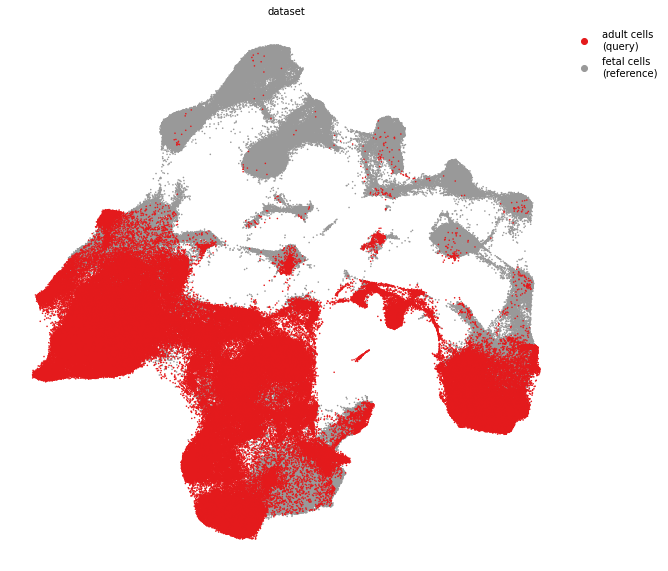

In [17]:
plt.rcParams["figure.figsize"] = [10,10]
merged_adata.obs['dataset_pl'] = ['fetal cells\n(reference)' if x=='reference' else 'adult cells\n(query)' for x in merged_adata.obs['dataset']]
scv.pl.umap(merged_adata, color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

Trying to set attribute `.uns` of view, copying.


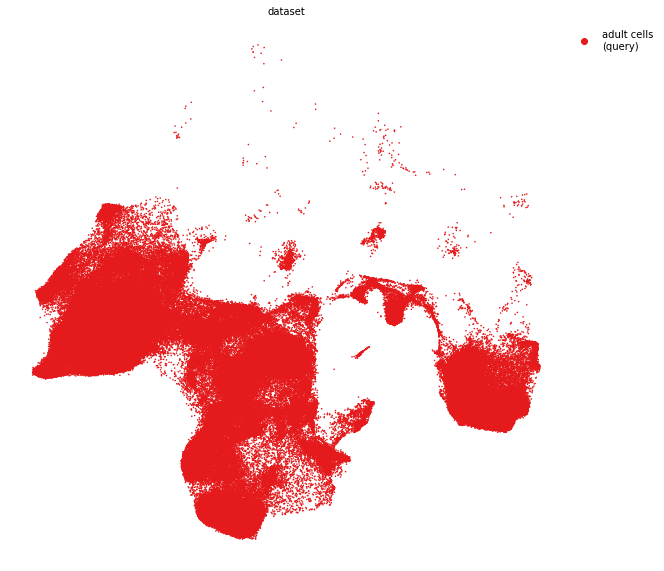

Trying to set attribute `.uns` of view, copying.


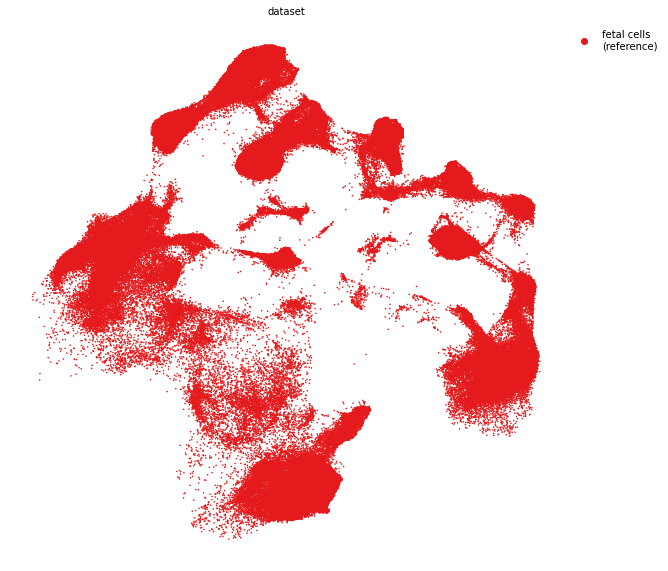

In [18]:
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'query'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'reference'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

In [19]:
merged_adata.obs["dataset"].value_counts()

query        264929
reference    239355
Name: dataset, dtype: int64

### Plot query and reference annotations

In [20]:
anno_labels_pl = {
    'Tnaive/CM_CD4_activated':'Tnaive/CM_CD4',
    'Tem/emra_CD8':'Trm/em_CD8',
    'Trm_gut_CD8':'Trm/em_CD8',
    'Tgd_CRTAM+':'Tgd',
    'Trm_Tgd':'Tgd',
    'GC_B (I)':'GC B',
    'GC_B (II)':'GC B'
}

plt.rcParams['figure.figsize'] = [12,12]
merged_adata.obs["annotation_query_pl"] = [anno_labels_pl[x] if x in anno_labels_pl.keys() else x for x in merged_adata.obs["annotation_query"]]
label_counts = merged_adata.obs["annotation_query_pl"].value_counts()
anno_labels = label_counts.index[label_counts > 10]

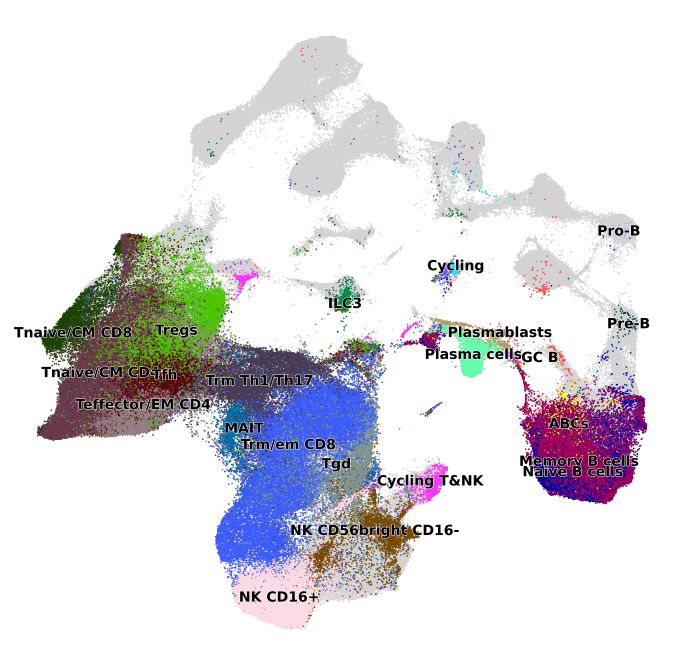

In [21]:
scv.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_loc="on data", groups=anno_labels, title="", 
            legend_fontsize=14, 
#             save="anno_query.png"
           )

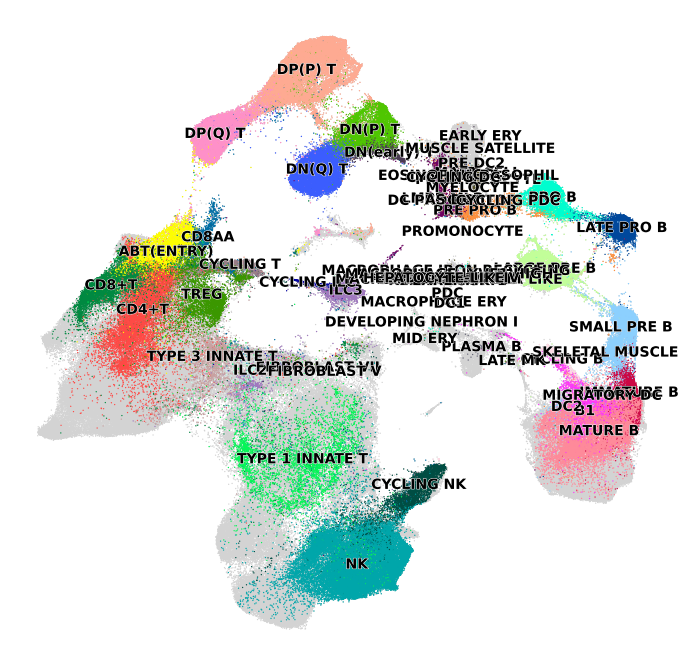

In [22]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=14,
            title="",
#            save="anno_reference.png"
           )

### Transfer labels

In [15]:
# # min_ref_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]/10
# missing_anno = merged_adata.obs["dataset"] == "query"

# ## Find neighbors of cells with conflicting annotation
# knn_graph = merged_adata.obsp['distances']
# knn_graph_query = knn_graph[missing_anno,:]
# # knn_graph_query[knn_graph_query.nonzero()] = 1

In [23]:
def predict_label2(merged_adata, anno_col = 'annotation_reference', k=50, min_score = 0.5):
    '''
    Predict annotation labels for query cells based on k-NNs in the reference data
    '''
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = merged_adata.obsm["X_scvi"].copy()

    is_query = merged_adata.obs["dataset"] == "query"
    is_reference = merged_adata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)

    knn_mat = np.zeros(shape=[sum(is_query),sum(is_reference)])
    for i in range(k_index_ref.shape[0]):
        knn_mat[i, k_index_ref[i]] = 1

    ## Subset to reference cells that have are NN to at least one query cell
    keep_ref_ixs = np.unique(k_index_ref.ravel())
    keep_ref_ixs.sort()
    small_knn_mat = knn_mat[:,keep_ref_ixs]

    ## Make dummy matrix of annotations
    annos = merged_adata[is_reference].obs[anno_col][keep_ref_ixs].copy()
    dummy_df = pd.get_dummies(annos)
    dummy_mat = dummy_df.values

    ## Sum number of neighbors with each annotation
    new_anno = small_knn_mat.dot(dummy_mat)

    ## Find top scorers
    n_neighbors = np.array(small_knn_mat.sum(1)).flatten()
    n_neighbors_ref = new_anno.sum(axis=1)
    new_anno_prob = new_anno.T/n_neighbors_ref
    new_anno_prob[np.isnan(new_anno_prob)] = 0
    best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
    best_label_score = new_anno_prob.max(0)
    best_label = best_label.astype('str')

    ## Call low confidence if probability is < min_score
    best_label_all = best_label.copy()
    best_label[best_label_score <= min_score] = "low_confidence"

    ## Save output in place
    del merged_adata.obs['predicted_anno'] 
    merged_adata.obs['predicted_anno'] = np.nan
    merged_adata.obs['predicted_anno_unfiltered'] = np.nan
    merged_adata.obs['predicted_anno_prob'] = np.nan
    merged_adata.obs.loc[is_query,'predicted_anno'] = best_label
    merged_adata.obs.loc[is_query,'predicted_anno_unfiltered'] = best_label_all
    merged_adata.obs.loc[is_query,'predicted_anno_prob'] = best_label_score

---

In [ ]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in merged_adata.obs.columns:
    merged_adata.obs.drop('predicted_anno', 1, inplace=True)
map_query_utils.predict_label2(merged_adata, anno_col="annotation_reference")

218.11098098754883


In [ ]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

In [ ]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

plt.rcParams["figure.figsize"] = [25,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [28]:
import time
## Calculate distance of a query cell to closest cell of 
# predicted annotation

def _compute_min_dist2predicted_anno(merged_adata, r_cl,
#                                      q_cell,
                                     r_obs = 'annotation_reference',
                                     pred_anno_obs = 'predicted_anno_unfiltered'
                                    ):
    # Pick reference cluster 
    keep_ref_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)
    keep_query_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[pred_anno_obs] == r_cl)

    ## Calculate distance of query cell to all reference
    # cells in cluster
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_ref_cells,:]
    X_dims_invitro = X_dims[keep_query_cells,:]
    k_ref = cKDTree(X_dims_invivo).query(x=X_dims_invitro, k=1, n_jobs=5)
    min_dists = k_ref[0]
    min_dists_df = pd.DataFrame(zip(merged_adata.obs_names[keep_query_cells],min_dists), columns=['query_cell', 'min_distance2pred'])
    return(min_dists_df)

start = time.time()
merged_adata.obs['min_distance2pred'] = np.nan
counter = 0
for r_cl in merged_adata.obs['predicted_anno_unfiltered'].unique():
    counter += 1
    min_dists_df = _compute_min_dist2predicted_anno(merged_adata, r_cl)
    merged_adata.obs.loc[min_dists_df.query_cell, 'min_distance2pred'] = min_dists_df.min_distance2pred.values
    print(counter)
## Normalize w gaussian kernel
merged_adata.obs.loc[is_query, 'min_distance2pred'] = map_query_utils._scArches_adjusted_dist(merged_adata.obs.loc[is_query, 'min_distance2pred'].astype('float').values)
end = time.time()
print(end-start)

KeyError: 'predicted_anno_unfiltered'

### Combined similarity & confusion matrix

In [193]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno", "annotation_query", 'organ code']]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

In [194]:
query_anno_group_lymphoid = {
    "B cells":[x for x in q_df.annotation_query.unique() if x.endswith("B") or "GC_B" in x or x=="B_prog" or "Plasma" in x or 'MemB' in x],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.startswith("NK")],
    "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['T cells'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

ref_anno_group_lymphoid = {
    "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
    'low_confidence':['low_confidence']
    }

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

In [196]:
%%R -i q_df -h 800 -w 1000 
q_df %>%
head()
#     group_by(annotation_query) %>%
#     mutate(tot_cells=n()) %>%
#     ungroup() %>%
#     group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
#     summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
#     ungroup() %>%
#     filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
#     mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
#     mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
#     mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) 
    
#     %>%
#     ggplot(aes(predicted_anno, annotation_query)) +
#     scale_size(range=c(1,8), name="Fraction\nof cells") +
#     geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
#     scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
#     facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
#     xlab("Predicted fetal cell type") + ylab("Adult cell type") +
#     theme_bw(base_size=22) +
#     theme(axis.text.x=element_text(angle=45, hjust=1)) +
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

                                    min_distance2pred predicted_anno
Pan_T7935490_AAACCTGCAAATTGCC-query         0.7441413           TH17
Pan_T7935490_AAACGGGCATCTGGTA-query         0.7247988             NK
Pan_T7935490_AAACGGGTCTTGCATT-query         0.7128636           NK_T
Pan_T7935490_AAAGCAATCATCGCTC-query         0.6584357             NK
Pan_T7935490_AAAGTAGCAGTCACTA-query         0.7047638      HIGH_MITO
Pan_T7935490_AACACGTTCCGTTGCT-query         0.6609065   low_confiden
                                    annotation_query organ code
Pan_T7935490_AAACCTGCAAATTGCC-query     Trm_Th1/Th17        ILE
Pan_T7935490_AAACGGGCATCTGGTA-query      Trm_gut_CD8        ILE
Pan_T7935490_AAACGGGTCTTGCATT-query      Trm_gut_CD8        ILE
Pan_T7935490_AAAGCAATCATCGCTC-query      Trm_gut_CD8        ILE
Pan_T7935490_AAAGTAGCAGTCACTA-query          Trm_Tgd        ILE
Pan_T7935490_AACACGTTCCGTTGCT-query          Trm_Tgd        ILE
                                    annotation_query_group predicted_

In [197]:
## Save for future plotting
q_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_LYMPHOID_query.mapped2LYMPHOID.confusion_table.csv')

### Save outputs

In [204]:
merged_adata.obs['min_distance2pred'] = merged_adata.obs['min_distance2pred'].astype('float')

In [205]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [12]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

#### Updated query annotation from Conde et al.

In [15]:
pi_adata_new = sc.read_h5ad('/nfs/team205/cx1/Celltypist/revision_science/data/PIP_global_object_raw_count.h5ad')

In [16]:
query_obs = merged_adata.obs_names[merged_adata.obs['dataset'] == 'query'].str.strip('-query')
query_obs = query_obs[query_obs.isin(pi_adata_new.obs_names)]
new_annos = pi_adata_new[query_obs].obs['Category'].values

merged_adata.obs['annotation_query'] = np.nan
merged_adata.obs.loc[query_obs+'-query','annotation_query'] = new_annos

In [17]:
merged_adata.obs['annotation_query'].unique()

array([nan, 'Trm_Th1/Th17', 'Trm_gut_CD8', 'Trm_Tgd', 'Trm/em_CD8',
       'Cycling T&NK', 'Memory B cells', 'Tregs', 'Naive B cells',
       'Plasma cells', 'Teffector/EM_CD4', 'Tem/emra_CD8', 'Tfh', 'ILC3',
       'Tnaive/CM_CD4', 'Tgd_CRTAM+', 'NK_CD16+', 'Tnaive/CM_CD8', 'MAIT',
       'ABCs', 'NK_CD56bright_CD16-', 'Cycling', 'GC_B (I)', 'GC_B (II)',
       'Tnaive/CM_CD4_activated', 'Plasmablasts', 'Progenitor', 'Pro-B',
       'Pre-B', 'Megakaryocytes', 'Erythroid', 'pDC',
       'Classical monocytes', 'DC2', 'Erythrophagocytic macrophages',
       'Intermediate macrophages'], dtype=object)

### Plot marker expression in mature B cells

In [35]:
merged_adata.var_names = merged_adata.var['GeneName'].astype('str').values.copy()

In [37]:
merged_adata.var_names_make_unique()

In [60]:
sc.pp.normalize_total(merged_adata,target_sum=10e04)

In [61]:
sc.pp.log1p(merged_adata)

In [62]:
query_ixs = merged_adata.obs['annotation_query'].isin(['GC_B (I)', 'GC_B (II)', "Naive B cells", "Memory B cells"])
ref_ixs = merged_adata.obs['annotation_reference']=="MATURE_B"

pl_adata = merged_adata[ ref_ixs | query_ixs ].copy()
pl_adata.obs['pl_annotation'] = np.nan
pl_adata.obs.loc[ref_ixs,'pl_annotation'] = pl_adata.obs.loc[ref_ixs, 'dataset'].astype('str') + "_" + pl_adata.obs.loc[ref_ixs, 'annotation_reference'].astype('str')
pl_adata.obs.loc[query_ixs,'pl_annotation'] = pl_adata.obs.loc[query_ixs, 'dataset'].astype('str') + "_" + pl_adata.obs.loc[query_ixs, 'annotation_query'].astype('str')

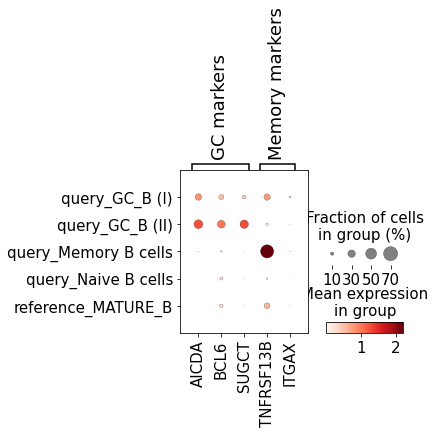

In [72]:
b_cell_markers = { ## Plucked from Conde et al.
    'GC markers':['AICDA','BCL6','SUGCT'],
    'Memory markers': ['TNFRSF13B','ITGAX']
}
plt.rcParams.update({'font.size': 18})
sc.pl.dotplot(pl_adata,
              b_cell_markers,
              groupby='pl_annotation', figsize=[4,3], save='matureB_expression.pdf')


### Compare similarity scores with myeloid

In [13]:
merged_adata_myeloid = sc.read_h5ad(data_dir + 'panimmune_MYELOID_query.mapped2MYELOID.withReference.h5ad')

In [57]:
sim_scores_lym = merged_adata.obs.loc[merged_adata.obs['dataset'] == 'query', 'mnn_sim_ratio'].values
sim_scores_mye = merged_adata_myeloid.obs.loc[merged_adata_myeloid.obs['dataset'] == 'query', 'mnn_sim_ratio'].values

In [59]:
scipy.stats.ks_2samp(sim_scores_lym, sim_scores_mye, alternative='greater')

KstestResult(statistic=0.21323754024300012, pvalue=0.0)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f27316f8150>,
 'caps': [<matplotlib.lines.Line2D at 0x7f27316f8310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f27316f8250>,
 'medians': [<matplotlib.lines.Line2D at 0x7f272f33fdd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f272f33f4d0>,
 'means': []}

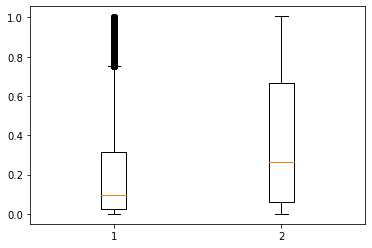

In [60]:
plt.boxplot([sim_scores_lym, sim_scores_mye])

In [78]:
df = pd.DataFrame(sim_scores_lym)
df['split'] = 'LYMPHOID'
df2 = pd.DataFrame(sim_scores_mye)
df2['split'] = 'MYELOID'
df = pd.concat([df, df2])

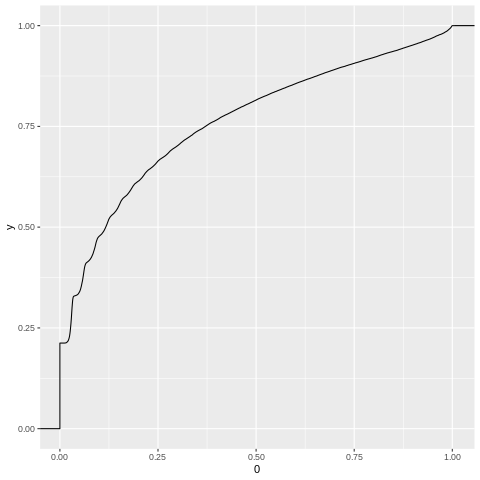

In [79]:
%%R -i df
df %>%
ggplot(aes(`0`)) +
stat_ecdf()

In [86]:
%%R 
ks.test(df$`0`[df$split=="LYMPHOID"], df$`0`[df$split=="MYELOID"], alternative='greater')
# df$sim_score[df$split=="LYMPHOID"]
# head(df$`0`)


	Two-sample Kolmogorov-Smirnov test

data:  df$`0`[df$split == "LYMPHOID"] and df$`0`[df$split == "MYELOID"]
D^+ = 0.21324, p-value < 2.2e-16
alternative hypothesis: the CDF of x lies above that of y



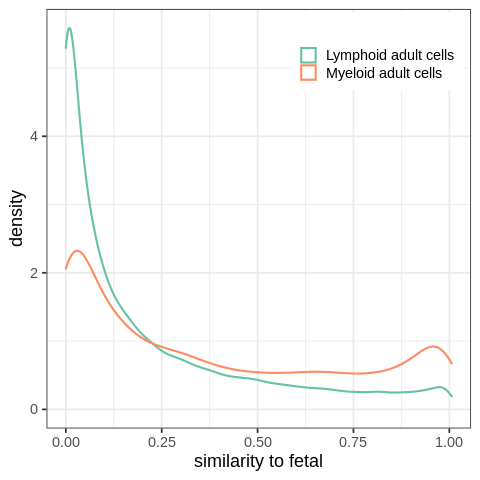

In [96]:
%%R -i figdir
df %>%
rename(sim_score=`0`) %>%
# filter(sim_score > 0) %>%
ggplot(aes(sim_score, color=split)) +
geom_density(size=1) +
# stat_ecdf() +
theme_bw(base_size=18) +
scale_color_brewer(palette='Set2', labels=c(LYMPHOID='Lymphoid adult cells', MYELOID='Myeloid adult cells'), name='') +
xlab("similarity to fetal") +
theme(legend.position=c(0.9, 0.9), legend.justification=c(hjust=0.8)) +
ggsave(paste0(figdir, 'lymphVSmye_similarity_score.pdf'), height=6, width=7)

## Mapping validation metrics

In [12]:
query_mapped_adata = merged_adata[merged_adata.obs['dataset'] == 'query'].copy()

sc.pp.neighbors(query_mapped_adata, use_rep='X_scvi', n_neighbors=30)

In [16]:
sc.tl.leiden(query_mapped_adata, resolution=0.5)

In [17]:
query_mapped_adata.obs['leiden'] = query_mapped_adata.obs['leiden'].astype("str")
query_mapped_adata.obs['annotation_query'] = query_mapped_adata.obs['annotation_query'].astype("str")

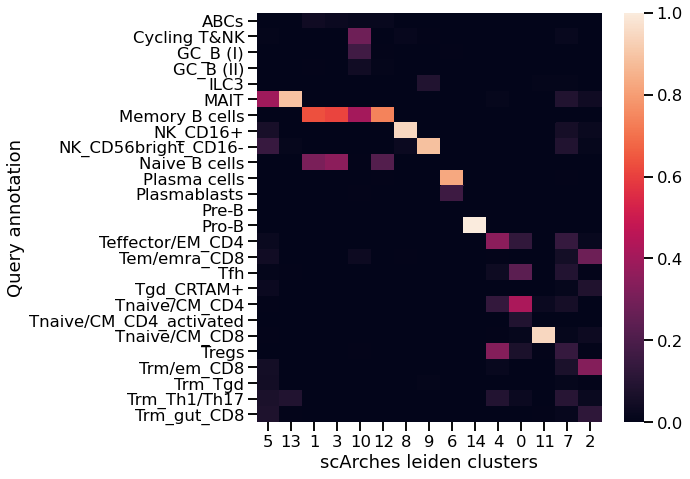

In [18]:
sns.set_context("talk")
keep_cts = query_mapped_adata.obs['annotation_query'].value_counts().index[query_mapped_adata.obs['annotation_query'].value_counts() > 10]
keep_cts = keep_cts[keep_cts!='nan']
conf_mat = sc.metrics.confusion_matrix('leiden','annotation_query', 
                                       query_mapped_adata.obs[query_mapped_adata.obs['annotation_query'].isin(keep_cts)]).T

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

plt.rcParams['figure.figsize'] = [10, 7]
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("scArches leiden clusters");
plt.ylabel("Query annotation");
plt.tight_layout();
plt.savefig(figdir + 'validation_conf_mat.pdf')

In [22]:
query_mapped_adata.obs.columns

Index(['n_counts', 'n_genes', 'file', 'mito', 'doublet_scores',
       'predicted_doublets', 'name', 'sample', 'Source ID', 'sex',
       'patient no', 'organ code', 'sample ID', 'fraction_mito', 'log_counts',
       'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score',
       'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval',
       'leiden', 'predicted_labels', 'over_clustering', 'majority_voting',
       'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno',
       'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2',
       'anno_B_v2', 'dataset', 'annotation_reference', 'annotation_query',
       'predicted_anno_prob', 'knn_sim', 'mnn_sim', 'mnn_sim_ratio',
       'precited_anno_prob', 'min_distance2pred', 'predicted_anno',
       'predicted_anno_unfiltered'],
      dtype='object')

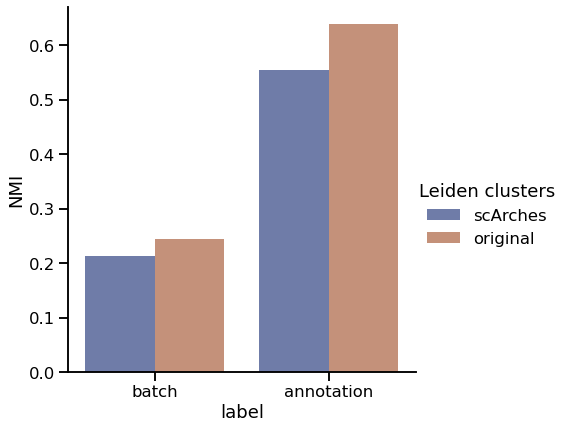

In [23]:
import sklearn
nmi_anno_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden5"])
nmi_anno_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden"])
nmi_batch_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden10"])
nmi_batch_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden"])

df = pd.DataFrame([nmi_batch_new, nmi_batch_old,nmi_anno_new, nmi_anno_old])
df.columns = ['NMI']
df['cat'] = ['batch_scArches', 'batch_original', 'annotation_scArches', "annotation_original"]
df['Leiden clusters'] = [x[1] for x in df['cat'].str.split("_")]
df['label'] = [x[0] for x in df['cat'].str.split("_")]

sns.catplot(
    data=df, kind="bar",
    x="label", y="NMI", hue='Leiden clusters',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.savefig(figdir + 'validation_barplot.pdf')

---